# 1. Data Setup

In [3]:
# Python chakin package install
!pip install chakin

# Common imports for our work
import os, time, re, cv2, chakin, json
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns
from collections import defaultdict
import tensorflow as tf
import scipy, sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from __future__ import division, print_function, unicode_literals

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# print(os.getcwd())

## 1.1 Download GloVe Embeddings

In [5]:
chakin.search(lang='English')  # lists available indices in English

                   Name  Dimension  ... Language    Author
2          fastText(en)        300  ...  English  Facebook
11         GloVe.6B.50d         50  ...  English  Stanford
12        GloVe.6B.100d        100  ...  English  Stanford
13        GloVe.6B.200d        200  ...  English  Stanford
14        GloVe.6B.300d        300  ...  English  Stanford
15       GloVe.42B.300d        300  ...  English  Stanford
16      GloVe.840B.300d        300  ...  English  Stanford
17    GloVe.Twitter.25d         25  ...  English  Stanford
18    GloVe.Twitter.50d         50  ...  English  Stanford
19   GloVe.Twitter.100d        100  ...  English  Stanford
20   GloVe.Twitter.200d        200  ...  English  Stanford
21  word2vec.GoogleNews        300  ...  English    Google

[12 rows x 7 columns]


In [0]:
# Specify English embeddings file to download and install by index number, number of dimensions, and subfoder name
# Note that GloVe 50-, 100-, 200-, and 300-dimensional folders are downloaded with a single zip download
CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "gloVe.6B"

In [0]:
DATA_FOLDER = "embeddings"
ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
if SUBFOLDER_NAME[-1] == "d":
    GLOVE_FILENAME = os.path.join(
        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
else:
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))

In [8]:
# download zip
if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    print("Downloading embeddings to '{}'".format(ZIP_FILE))
    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
else:
    print("Embeddings already downloaded.")


Test: 100% ||                                      | Time:  0:06:27   2.1 MiB/s


In [9]:
print(os.path.join('/embeddings/', 'glove.6B.zip'))

/embeddings/glove.6B.zip


In [10]:
# unzip file
if not os.path.exists(UNZIP_FOLDER):
    import zipfile
    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
        ZIP_FILE = ZIP_FILE_ALT
    with zipfile.ZipFile("embeddings/glove.6B.zip", "r") as zip_ref:
        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
        zip_ref.extractall(UNZIP_FOLDER)
else:
    print("Embeddings already extracted.")

print('\nRun complete')

Extracting embeddings to 'embeddings/gloVe.6B'

Run complete


## 1.2 Read Movie Reviews

In [11]:
# Common imports for our work
from __future__ import absolute_import # from __future__ import absolute_import
from __future__ import division # Changing the Division Operator
from __future__ import print_function #Make print a function

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import numpy as np # import numpy
import os  # operating system functions
import os.path  # for manipulation of file path names
import re  # regular expressions
from collections import defaultdict # dict subclass that calls a factory function to supply missing values

import nltk # Natural Language Toolkit
from nltk.tokenize import TreebankWordTokenizer #tokenize text


## Plot
from matplotlib import pyplot

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TreebankWordTokenizer

# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import tensorflow as tf #TensorFlow
import time # Record processing time

Using TensorFlow backend.


In [0]:
REMOVE_STOPWORDS = False  # no stopword removal

In [0]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 9999

In [0]:
EVOCABSIZE = 10000  # specify desired size of pre-defined embedding vocabulary 

In [0]:
# ------------------------------------------------------------- 
# Select the pre-defined embeddings source        
# Define vocabulary size for the language model    
# Create a word_to_embedding_dict for GloVe.6B.50d
embeddings_directory = 'embeddings/gloVe.6B'
filename = 'glove.6B.50d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)
# ------------------------------------------------------------- 

In [0]:
# Load a embedding text file
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`, we return a tuple of two dictionaries 
    `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct 
    `word_to_embedding_dict` dictionary mapping from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


In [17]:
# Check if the loaded embedding files glove.6B.50d. successfully.   "glove.6B.50d."was ontained though "run-chakin-to-get-embeddings-v001.py"
print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")

# Note: unknown words have representations with values [0, 0, ..., 0]


Loading embeddings from embeddings/gloVe.6B/glove.6B.50d.txt
Embedding loaded from disks.


In [18]:
# Additional background code from
# https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer
# shows the general structure of the data structures for word embeddings
# This code is modified for our purposes in language modeling 

# Check vocabrary size and embedding dimention
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

#Check embedding data
print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (400001, 50)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation
    worsdfkljsdf --> 400000 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    the --> 0 --> [0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566, 0.27843, -0.14767, -0.55677, 0.14658, -0.0095095, 0.011658, 0.10204, -0.12792, -0.8443, -0.12181, -0.016801, -0.33279, -0.1552, -0.23131, -0.19181, -1.8823, -0.76746, 0.099051, -0.42125, -0.19526, 4.0071, -0.18594, -0.52287, -0.31681, 0.00059213, 0.0074449, 0.17778, -0.15897, 0.012041, -0.054223, -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18

In [19]:
# Show how to use embeddings dictionaries with a test sentence
# This is a famous typing exercise with all letters of the alphabet
# https://en.wikipedia.org/wiki/The_quick_brown_fox_jumps_over_the_lazy_dog
a_typing_test_sentence = 'The quick brown fox jumps over the lazy dog'
print('\nTest sentence: ', a_typing_test_sentence, '\n')
words_in_test_sentence = a_typing_test_sentence.split()

print('Test sentence embeddings from complete vocabulary of', 
      complete_vocabulary_size, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding[word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence:  The quick brown fox jumps over the lazy dog 

Test sentence embeddings from complete vocabulary of 400000 words:

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.25

In [0]:
# ------------------------------------------------------------- 
# Define vocabulary size for the language model    
# To reduce the size of the vocabulary to the n most frequently used words

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})


In [0]:
# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]

# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

In [22]:
# Verify the new vocabulary: should get same embeddings for test sentence
# Note that a small EVOCABSIZE may yield some zero vectors for embeddings
print('\nTest sentence embeddings from vocabulary of', EVOCABSIZE, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = limited_index_to_embedding[limited_word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence embeddings from vocabulary of 10000 words:

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.25819   -0.094902
  0.79478   -1.2095    -0.01039   -0.092086   0.84322   

In [0]:
# ------------------------------------------------------------
# code for working with movie reviews data 
# Source: Miller, T. W. (2016). Web and Network Data Science.
#    Upper Saddle River, N.J.: Pearson Education.
#    ISBN-13: 978-0-13-388644-3
# This original study used a simple bag-of-words approach
# to sentiment analysis, along with pre-defined lists of
# negative and positive words.        
# Code available at:  https://github.com/mtpa/wnds       
# ------------------------------------------------------------

# Utility function to get file names within a directory
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

In [0]:
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

In [0]:
# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
    more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 

    some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

    # start with the initial list and add to it for movie text work 
    stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
        some_proper_nouns_to_remove

In [0]:
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]  
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)  

In [27]:
print(os.getcwd())

/content


In [41]:
# -----------------------------------------------
# Download and install both negtive and positive movies reviews from the Technology Resources Section 
# within the Jump Start Program for Assignment 8 Module. This entails saving the 'movie-reviews-negative'
# and 'movie-reviews-positive' directories from the run-jump-start-rnn-sentiment-v002.zip 
# or  run-jump-start-rnn-sentiment-big-v002.zip file to your working directory
# -----------------------------------------------

# -----------------------------------------------
# gather data for 500 negative movie reviews
# -----------------------------------------------

# Set path to the negative word dictionary, "moive-reviews-negative"
dir_name = 'movie-reviews-negative'
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))


Directory: movie-reviews-negative
500 files found


In [42]:
# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents 
# a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

negative_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))



Processing document files under movie-reviews-negative


In [43]:
# -----------------------------------------------
# gather data for 500 positive movie reviews
# -----------------------------------------------

# Set path to the positive word dictionary, "moive-reviews-positive"
dir_name = 'movie-reviews-positive'  
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))


Directory: movie-reviews-positive
500 files found


In [44]:
# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

positive_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))



Processing document files under movie-reviews-positive


In [45]:
# -----------------------------------------------------
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
# -----------------------------------------------------

max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

max_review_length: 1052
min_review_length: 22


In [0]:
# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))

## 1.3 Get Word Embeddings from Glove

In [0]:
vocabulary_size = 10000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

In [48]:
embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [0]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [51]:
X_train.shape

(800, 50)

In [52]:
y_train.shape

(800,)

# 2. Model Setup

In [0]:
# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [0]:
#Training base model by using RNN backpropagation through time (BPTT).
reset_graph() # Refresh graph to make output stable across runs

## 2.1 RNN with LSTM
Vocabulary size 10,000

In [55]:
model = Sequential()
model.add(Embedding(EVOCABSIZE, 50, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            16064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        


In [56]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 800 samples, validate on 200 samples
Epoch 1/30





800/800 [==============================] - 2s 3ms/step - loss: 0.6939 - acc: 0.4850 - val_loss: 0.6932 - val_acc: 0.4650
Epoch 2/30
800/800 [==============================] - 1s 774us/step - loss: 0.6923 - acc: 0.5212 - val_loss: 0.6943 - val_acc: 0.4700
Epoch 3/30
800/800 [==============================] - 1s 794us/step - loss: 0.6905 - acc: 0.5437 - val_loss: 0.6929 - val_acc: 0.4700
Epoch 4/30
800/800 [==============================] - 1s 800us/step - loss: 0.6880 - acc: 0.5413 - val_loss: 0.6908 - val_acc: 0.5500
Epoch 5/30
800/800 [==============================] - 1s 843us/step - loss: 0.6819 - acc: 0.5825 - val_loss: 0.6890 - val_acc: 0.5450
Epoch 6/30
800/800 [==============================] - 1s 812us/step - loss: 0.6727 - acc: 0.6025 - val_loss: 0.6995 - val_acc: 0.5000
Epoch 7/30
800/800 [============================

In [57]:
batch_size = 64

score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

800/800 [==============================] - 0s 127us/step
Train score: 0.02852854400873184
Train accuracy: 1.0
200/200 [==============================] - 0s 141us/step
Test score: 0.9401653575897216
Test accuracy: 0.61


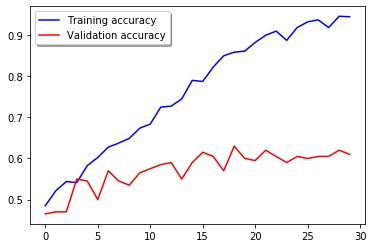

In [58]:
# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

## 2.2 RNN with LSTM
Embedded vocabulary size increased to 30,000

In [0]:
vocabulary_size = 30000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

In [60]:
embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [0]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [62]:
model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            1500000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            16064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,539,115
Trainable params: 39,115
Non-trainable params: 1,500,000
_______________________________________

In [63]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 2s 2ms/step - loss: 0.6934 - acc: 0.5038 - val_loss: 0.6930 - val_acc: 0.4750
Epoch 2/30
800/800 [==============================] - 1s 823us/step - loss: 0.6923 - acc: 0.5212 - val_loss: 0.6927 - val_acc: 0.4950
Epoch 3/30
800/800 [==============================] - 1s 850us/step - loss: 0.6900 - acc: 0.5413 - val_loss: 0.6902 - val_acc: 0.5750
Epoch 4/30
800/800 [==============================] - 1s 840us/step - loss: 0.6846 - acc: 0.6100 - val_loss: 0.6901 - val_acc: 0.5050
Epoch 5/30
800/800 [==============================] - 1s 846us/step - loss: 0.6769 - acc: 0.5862 - val_loss: 0.6885 - val_acc: 0.5200
Epoch 6/30
800/800 [==============================] - 1s 819us/step - loss: 0.6639 - acc: 0.6112 - val_loss: 0.6731 - val_acc: 0.5950
Epoch 7/30
800/800 [==============================] - 1s 851us/step - loss: 0.6440 - acc: 0.6400 - val_loss: 0.6657 - val_acc: 0.5800
Epoch 8/30
800/800

800/800 [==============================] - 0s 121us/step
Train score: 0.030253894999623297
Train accuracy: 1.0
200/200 [==============================] - 0s 131us/step
Test score: 0.9007147288322449
Test accuracy: 0.595


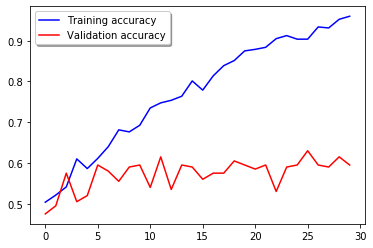

In [64]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

## 2.3 RNN with LSTM
Use glove embeddings



In [65]:
vocabulary_size = 10000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [0]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [67]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,098,165
Trainable params: 98,165
Non-trainable params: 1,000,000
_______________________________________

In [68]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 2s 3ms/step - loss: 0.6964 - acc: 0.4725 - val_loss: 0.6947 - val_acc: 0.4700
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6913 - acc: 0.5325 - val_loss: 0.6911 - val_acc: 0.5900
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6882 - acc: 0.5375 - val_loss: 0.6886 - val_acc: 0.5850
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6756 - acc: 0.6675 - val_loss: 0.6761 - val_acc: 0.5900
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6503 - acc: 0.6212 - val_loss: 0.6584 - val_acc: 0.6000
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.5819 - acc: 0.7075 - val_loss: 0.6811 - val_acc: 0.5900
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.5543 - acc: 0.7063 - val_loss: 0.6444 - val_acc: 0.6050
Epoch 8/30
800/800 [==========

800/800 [==============================] - 0s 174us/step
Train score: 0.004202920012176037
Train accuracy: 1.0
200/200 [==============================] - 0s 186us/step
Test score: 1.06438818693161
Test accuracy: 0.575


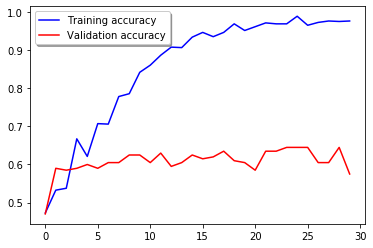

In [69]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

## 2.4 RNN with LSTM
Use gloVe embeddings, increase vocabulary size to 30,000

---



In [70]:
vocabulary_size = 30000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [0]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [72]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           3000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 3,098,165
Trainable params: 98,165
Non-trainable params: 3,000,000
_______________________________________

In [73]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 3s 4ms/step - loss: 0.6931 - acc: 0.5025 - val_loss: 0.6934 - val_acc: 0.4700
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6896 - acc: 0.5487 - val_loss: 0.6895 - val_acc: 0.6400
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6788 - acc: 0.6013 - val_loss: 0.6796 - val_acc: 0.6150
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6440 - acc: 0.6300 - val_loss: 0.6714 - val_acc: 0.5600
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6203 - acc: 0.6450 - val_loss: 0.6654 - val_acc: 0.5850
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6144 - acc: 0.6750 - val_loss: 0.6622 - val_acc: 0.5850
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.5584 - acc: 0.7087 - val_loss: 0.6623 - val_acc: 0.5800
Epoch 8/30
800/800 [==========

800/800 [==============================] - 0s 179us/step
Train score: 0.0021701662056148054
Train accuracy: 1.0
200/200 [==============================] - 0s 195us/step
Test score: 1.113481764793396
Test accuracy: 0.65


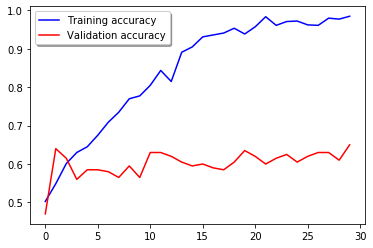

In [74]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

## modify model hyperparameter settings

In [0]:
reset_graph() # Refresh graph to make output stable across runs

In [76]:
vocabulary_size = 30000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [0]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [78]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,098,165
Trainable params: 98,165
Non-trainable params: 3,000,000
_______________________________________

In [0]:
# from keras.optimizers import adam

# # compile model
# opt = optimizers.RMSprop(lr=1e-5)
# model.compile(loss='binary_crossentropy',
#               optimizer=opt,   
#               metrics=['accuracy'])

# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

In [80]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 2s 2ms/step - loss: 0.1317 - acc: 0.9487 - val_loss: 0.8539 - val_acc: 0.6200
Epoch 2/30
800/800 [==============================] - 1s 754us/step - loss: 0.1462 - acc: 0.9438 - val_loss: 0.8526 - val_acc: 0.6200
Epoch 3/30
800/800 [==============================] - 1s 735us/step - loss: 0.1256 - acc: 0.9600 - val_loss: 0.9065 - val_acc: 0.6050
Epoch 4/30
800/800 [==============================] - 1s 755us/step - loss: 0.1306 - acc: 0.9500 - val_loss: 0.9490 - val_acc: 0.6050
Epoch 5/30
800/800 [==============================] - 1s 723us/step - loss: 0.1064 - acc: 0.9587 - val_loss: 0.9655 - val_acc: 0.5900
Epoch 6/30
800/800 [==============================] - 1s 685us/step - loss: 0.1189 - acc: 0.9513 - val_loss: 0.9257 - val_acc: 0.6400
Epoch 7/30
800/800 [==============================] - 1s 670us/step - loss: 0.1100 - acc: 0.9637 - val_loss: 0.8612 - val_acc: 0.6200
Epoch 8/30
800/800

800/800 [==============================] - 0s 122us/step
Train score: 0.009456958286464215
Train accuracy: 1.0
200/200 [==============================] - 0s 139us/step
Test score: 1.0271145009994507
Test accuracy: 0.605


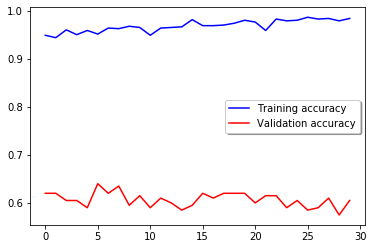

In [81]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)